In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
#Save references to each table
Measurements = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [14]:
#how far back does this climate data go
Thewaybackmachine = session.query(func.max(func.strftime("%Y-%m-%d", Measurements.date))).limit(5).all()
Thewaybackmachine[0][0]

'2017-08-23'

In [41]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
RainyDays = session.query(func.strftime("%Y-%m-%d", Measurements.date), Measurements.prcp).\
            filter(func.strftime("%Y-%m-%d", Measurements.date) >= dt.date(2016, 8, 23)).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
RainyDays_df = pd.DataFrame(RainyDays, columns = ["date", "precipitation"])
RainyDays_df
# Sort the dataframe by date
RainyDays_df.set_index("date", inplace=True)
RainyDays_df = RainyDays_df.sort_values(by="date")
RainyDays_df.head()
# Use Pandas Plotting with Matplotlib to plot the data


,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


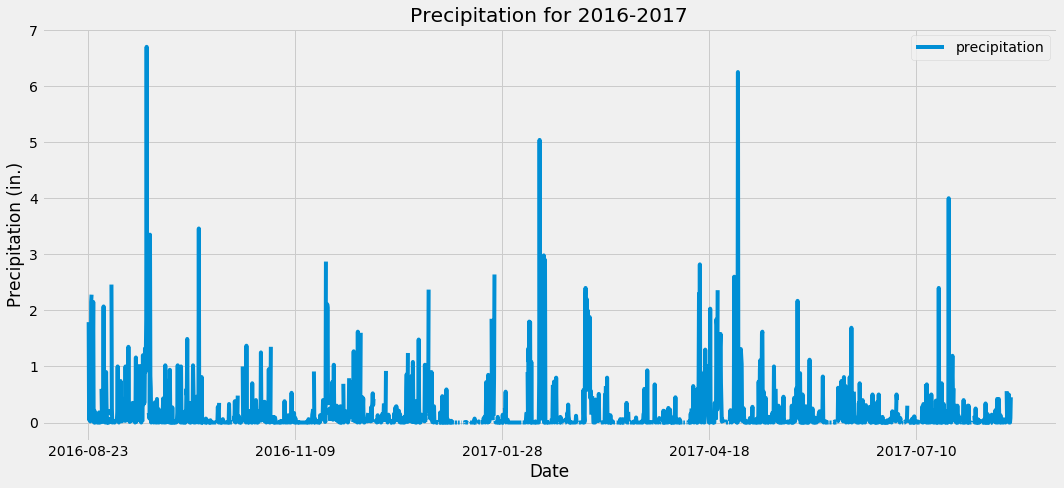

In [105]:
'''
ax = plt.subplots(figsize = (20, 10))
RainyDays_df.plot(#ax=ax, x_compact=True#)

ax.set_xlabel("Date")
ax.set_ylabel("Precipitation (in.)")
ax.set_title("Precipitation for 2016")

plt.savefig("Images/precipitation.png")

plt.tight_layout()
plt.show()
'''
fig, ax = plt.subplots(figsize = (15, 7))   
RainyDays_df.plot(ax = ax, x_compat = True)

#set title and labels
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in.)')
ax.set_title("Precipitation for 2016-2017")

#save figure
plt.savefig("Images/precipitation.png")

#plot figure
plt.tight_layout()
plt.show()

In [26]:
# Use Pandas to calcualte the summary statistics for the precipitation data
RainyDays_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [53]:
# Design a query to show how many stations are available in this dataset?
Stations = session.query(Station.id).distinct().count()
Stations

9

In [57]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
NumberofStations = (session.query(Measurements.station, func.count(Measurements.station))
                   .group_by(Measurements.station)
                   .order_by(func.count(Measurements.station).desc())
                    .all())
NumberofStations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [62]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
BestStation = "USC00519281"
Temperature = session.query(func.min(Measurements.tobs), func.max(Measurements.tobs), func.avg(Measurements.tobs)).\
filter(Measurements.station == BestStation).all()
Temperature

[(54.0, 85.0, 71.66378066378067)]

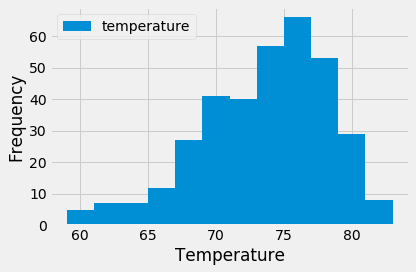

In [88]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Temperatures = session.query(Measurements.date, Measurements.tobs).filter(Measurements.station == BestStation).\
    filter(func.strftime("%Y-%m-%d", Measurements.date) >= dt.date(2016, 8, 23)).all()
Temperatures_df = pd.DataFrame(temp_observation, columns = ['date', 'temperature'])

fig, ax = plt.subplots()
Temperatures_df.plot.hist(bins = 12, ax = ax)

ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')

plt.savefig("Images/yearly_plot.png")

plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [89]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [90]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
TripTemperatures = calc_temps('2017-04-02','2017-04-09')
TripTemperatures

[(67.0, 74.42, 79.0)]

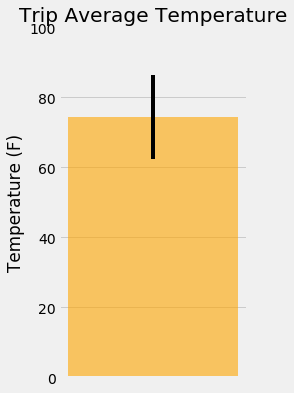

In [92]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
MiniumTemmp = TripTemperatures[0][0]
AverageTemp = TripTemperatures[0][1]
MaxiumTemp = TripTemperatures[0][2]

MiniumError = AverageTemp - MiniumTemmp
MaxiumError = MaxiumTemp - AverageTemp

plt.figure(figsize=(3,6))
plt.bar(0, AverageTemp, yerr=[MaxiumTemp-MiniumTemmp], color = 'orange', alpha=.6)
plt.title('Trip Average Temperature')
plt.ylim(0,100)
plt.ylabel('Temperature (F)')
plt.xticks([])

plt.show()

In [93]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

Begin = '2017-04-02'
End = '2017-04-09'

s = session.query(Station.station,
                  func.sum(Measurements.prcp),
                  Station.name,
                  Station.elevation,                                    
                  Station.latitude,
                  Station.longitude)\
.filter(Measurements.station == Station.station)\
.filter(Measurements.date >= Begin)\
.filter(Measurements.date <= End)\
.group_by(Station.station)\
.order_by(func.sum(Measurements.prcp).desc())

for row in s:
    rain="{0:.2f}".format(row[1])
    print (f"Station:  {row[0]}\n    Rainfall:  {rain}  \n    Location:  {row[2]}\n    Elevation:  {row[3]}  \
    Latitude:  {row[4]}  Longitude:  {row[5]}")
    print()

Station:  USC00516128
    Rainfall:  0.70  
    Location:  MANOA LYON ARBO 785.2, HI US
    Elevation:  152.4      Latitude:  21.3331  Longitude:  -157.8025

Station:  USC00519281
    Rainfall:  0.51  
    Location:  WAIHEE 837.5, HI US
    Elevation:  32.9      Latitude:  21.45167  Longitude:  -157.84888999999998

Station:  USC00514830
    Rainfall:  0.16  
    Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
    Elevation:  7.0      Latitude:  21.5213  Longitude:  -157.8374

Station:  USC00513117
    Rainfall:  0.16  
    Location:  KANEOHE 838.1, HI US
    Elevation:  14.6      Latitude:  21.4234  Longitude:  -157.8015

Station:  USC00519523
    Rainfall:  0.00  
    Location:  WAIMANALO EXPERIMENTAL FARM, HI US
    Elevation:  19.5      Latitude:  21.33556  Longitude:  -157.71139

Station:  USC00519397
    Rainfall:  0.00  
    Location:  WAIKIKI 717.2, HI US
    Elevation:  3.0      Latitude:  21.2716  Longitude:  -157.8168

Station:  USC00517948
    Rainfall:  0.00  
    Locatio

In [94]:
YearlyRainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude,
                               Station.elevation, func.avg(Measurements.prcp)).\
    filter(Measurements.station == Station.station).\
    filter(func.strftime("%Y-%m-%d", Measurements.date) >= dt.date(2016, 8, 23)).group_by(Station.station).\
    order_by(func.avg(Measurements.prcp).desc()).all()

#load into a dataframe
YearlyRainfall_df = pd.DataFrame(YearlyRainfall, columns = ['Station', 'Name', 'Latitude', 'Longitude', 
                                                              'Elevation', 'Avg. Precipitation (in.)'])

YearlyRainfall_df

,Station,Name,Latitude,Longitude,Elevation,Avg. Precipitation (in.)
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.450640
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.198949
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.141429
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.125434
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.121051
5,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.076500
6,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.044819


In [95]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurements.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [107]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
trip_dates = ["01-04", "01-05", "01-06", "01-07", "01-08", "01-09", "01-10", "01-11", "01-12", "01-13", "01-14",
             "01-15", "01-16", "01-17", "01-18"]
daily_norms = []

for trip_date in trip_dates:
    day = {}
    day['Date'] = f"2019-{trip_date}"
    daily_norm = daily_normals(trip_date)
    day['Min'] = daily_norm[0][0]
    day['Avg'] = daily_norm[0][1]
    day['Max'] = daily_norm[0][2]
    daily_norms.append(day)
    
daily_norms
# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[{'Date': '2019-01-04', 'Min': 58.0, 'Avg': 70.0, 'Max': 76.0},
 {'Date': '2019-01-05', 'Min': 56.0, 'Avg': 67.96428571428571, 'Max': 76.0},
 {'Date': '2019-01-06', 'Min': 61.0, 'Avg': 68.96491228070175, 'Max': 76.0},
 {'Date': '2019-01-07', 'Min': 57.0, 'Avg': 68.54385964912281, 'Max': 76.0},
 {'Date': '2019-01-08', 'Min': 57.0, 'Avg': 67.16071428571429, 'Max': 75.0},
 {'Date': '2019-01-09', 'Min': 58.0, 'Avg': 67.9298245614035, 'Max': 78.0},
 {'Date': '2019-01-10', 'Min': 62.0, 'Avg': 69.74137931034483, 'Max': 77.0},
 {'Date': '2019-01-11', 'Min': 57.0, 'Avg': 67.3103448275862, 'Max': 78.0},
 {'Date': '2019-01-12', 'Min': 57.0, 'Avg': 67.4074074074074, 'Max': 81.0},
 {'Date': '2019-01-13', 'Min': 57.0, 'Avg': 67.25454545454545, 'Max': 77.0},
 {'Date': '2019-01-14', 'Min': 58.0, 'Avg': 69.52631578947368, 'Max': 77.0},
 {'Date': '2019-01-15', 'Min': 56.0, 'Avg': 69.31372549019608, 'Max': 78.0},
 {'Date': '2019-01-16', 'Min': 54.0, 'Avg': 68.62962962962963, 'Max': 80.0},
 {'Date': '2019

In [108]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
#load into a data frame
daily_norms_df = pd.DataFrame(daily_norms)

#set index
daily_norms_df.set_index('Date', inplace = True)

#display
daily_norms_df

,Min,Avg,Max
Date,,,
2019-01-04,58.0,70.000000,76.0
2019-01-05,56.0,67.964286,76.0
2019-01-06,61.0,68.964912,76.0
2019-01-07,57.0,68.543860,76.0
2019-01-08,57.0,67.160714,75.0
2019-01-09,58.0,67.929825,78.0
2019-01-10,62.0,69.741379,77.0
2019-01-11,57.0,67.310345,78.0
2019-01-12,57.0,67.407407,81.0


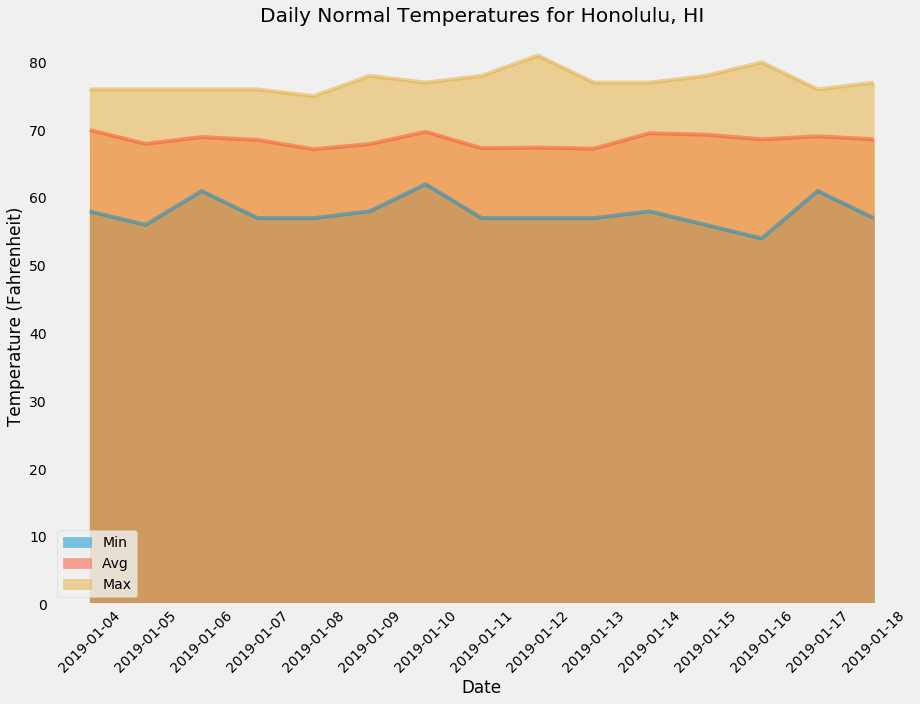

In [98]:
# Plot the daily normals as an area plot with `stacked=False`
#plot
fig, ax = plt.subplots(figsize = (13, 10))
daily_norms_df.plot.area(ax = ax, stacked = False)

#set labels
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (Fahrenheit)')
ax.set_title('Daily Normal Temperatures for Honolulu, HI')

#set ticks
dates = [f"2019-{trip_date}" for trip_date in trip_dates]
ax.set_xticks(np.arange(len(dates)))
ax.set_xticklabels(dates, rotation = 45)

#save figure
plt.savefig('Images/DailyNorms.png')

#show
plt.grid()
plt.tight_layout()
plt.show()

In [83]:
# This code was made with the Help of Aranza, Luara and the following
# https://github.com/ejhagee/Surfs-Up/blob/master/Surfs_Up!_code.ipynb
# https://github.com/djcim402/Surfs-Up-SQLAlchemy-Homework/blob/master/climate_starter.ipynb    